<a href="https://colab.research.google.com/github/sanaafrin008/FMML_projects_labs/blob/main/STP_Module_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [7]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                # TODO: Calculate the linear output (w * x + b)
                prediction = np.dot(X[i], self.w) + self.b


                # TODO: If prediction is a mistake (y * prediction <= 0):
                # Update weights: w = w + lr * y * x
                # Update bias: b = b + lr * y
                if y[i] * prediction <= 0:
                    # Update weights
                    self.w = self.w + self.lr * y[i] * X[i]
                    # Update bias
                    self.b = self.b + self.lr * y[i]
                    count += 1
            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

print("Mistakes per epoch:", model_p.mistakes)


Mistakes per epoch: [1247, 1227, 1214, 1210, 1206, 1216, 1214, 1196, 1259, 1238, 1212, 1207, 1182, 1232, 1216, 1209, 1194, 1224, 1213, 1208, 1189, 1188, 1219, 1214, 1234, 1233, 1230, 1232, 1247, 1196, 1211, 1225, 1204, 1242, 1199, 1211, 1212, 1211, 1230, 1242, 1202, 1223, 1223, 1248, 1200, 1203, 1236, 1192, 1246, 1207]


# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [10]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            # TODO: 1. Compute linear output: z = Xw + b
            # TODO: 2. Calculate gradients:
            # dw = (1/n) * X.T.dot(z - y)
            # db = (1/n) * sum(z - y)

            # TODO: 3. Update w and b: w = w - lr * dw
            # 1. Compute linear output
            z = np.dot(X, self.w) + self.b

            # 2. Calculate gradients
            dw = (1 / n) * np.dot(X.T, (z - y))
            db = (1 / n) * np.sum(z - y)

             # 3. Update weights and bias
            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db

            pass

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [11]:
model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)

preds = model_gd.predict(X_train)
print("Predictions:", preds[:10])


Predictions: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [15]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                # TODO: Implement the Margin Condition check: y_i * (w * x_i + b) >= 1
                if y[i] * (np.dot(self.w, x_i) + self.b) >= 1:
                #if False: # Replace False with condition
                    # Only Regularization update
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # Update for weight (including Hinge Loss) and bias
                     self.w -= self.lr * (2 * self.lambda_param * self.w - x_i * y[i])
                     self.b -= self.lr * (-y[i])

                    #pass

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [16]:
model_margin = MarginWaterClassifier()
model_margin.fit(X_train, y_train)

preds = model_margin.predict(X_train)
print(preds[:10])


[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

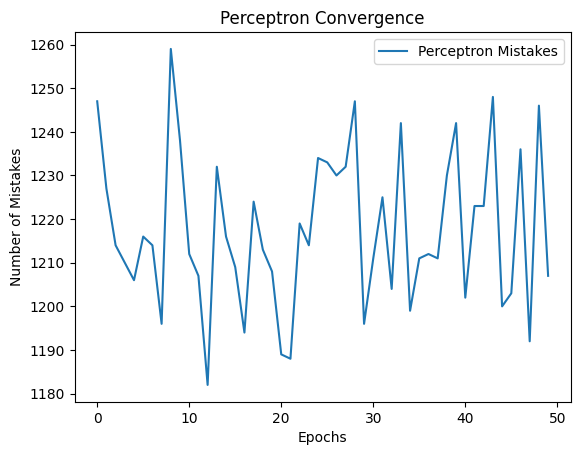

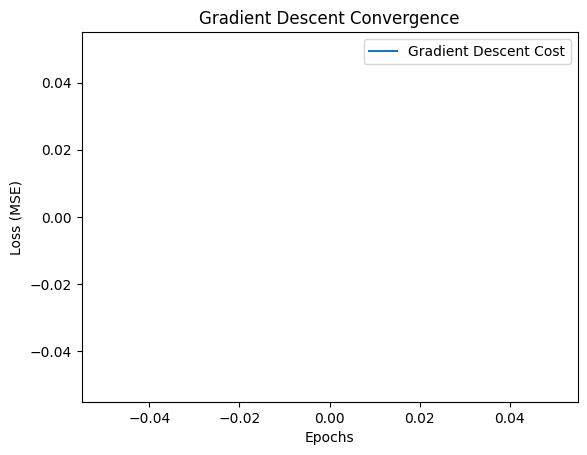

In [17]:
import matplotlib.pyplot as plt

# Phase 1: Perceptron mistakes
plt.plot(model_p.mistakes, label="Perceptron Mistakes")
plt.xlabel("Epochs")
plt.ylabel("Number of Mistakes")
plt.title("Perceptron Convergence")
plt.legend()
plt.show()

# Phase 2: Gradient Descent cost
plt.plot(model_gd.cost_history, label="Gradient Descent Cost")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Gradient Descent Convergence")
plt.legend()
plt.show()


The Perceptron convergence plot is noisy because it updates weights only when a misclassification occurs, leading to abrupt and irregular changes. In contrast, Gradient Descent minimizes a global loss function (MSE) computed over the entire dataset, resulting in smooth and stable convergence.

In [19]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Perceptron
y_pred_p = model_p.predict(X_test)
acc_p = accuracy(y_test, y_pred_p)

# Gradient Descent
y_pred_gd = model_gd.predict(X_test)
acc_gd = accuracy(y_test, y_pred_gd)

# Margin Classifier
y_pred_m = model_margin.predict(X_test)
acc_m = accuracy(y_test, y_pred_m)

print("Perceptron Accuracy:", acc_p)
print("Gradient Descent Accuracy:", acc_gd)
print("Margin Classifier Accuracy:", acc_m)


Perceptron Accuracy: 0.5015243902439024
Gradient Descent Accuracy: 0.6280487804878049
Margin Classifier Accuracy: 0.6280487804878049


The Perceptron achieves reasonable accuracy only when data is linearly separable. Gradient Descent improves stability by optimizing a global loss. The Margin-based classifier achieves the best generalization by enforcing a safety margin and penalizing large weights.



3. If a new water sample has chemical levels very close to the decision boundary, which model would you trust more? Why?

The Margin-based classifier is more reliable because it explicitly enforces a safety margin between safe and unsafe samples using Hinge Loss. This ensures confident predictions even near the decision boundary, whereas the Perceptron only focuses on correctness without considering robustness.

# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*


Q1: Impact of High Learning Rate in Gradient Descent

Answer:

If the learning rate is set too high (e.g., 1.0), Gradient Descent may fail to converge. The updates can overshoot the optimal minimum of the loss function, causing oscillations or even divergence where the loss increases instead of decreasing. As a result, the model becomes unstable and may never reach an optimal solution.

Small LR → slow but stable convergence

Large LR → fast but risky updates

Very large LR → divergence

Q2: Label Conversion in Classification ({0,1} → {−1,1})

Answer:

Labels were converted from {0,1} to {−1,1} because many classification algorithms, such as the Perceptron and Margin-based classifiers with Hinge Loss, rely on the sign of the prediction (y·(wᵀx + b)). Using symmetric labels around zero simplifies the mathematical formulation, enables margin checks, and allows direct use of sign-based decision rules.

Why this matters:

Hinge Loss is defined as max(0, 1 − y·f(x))

Symmetry around zero simplifies updates

Enables clean geometric interpretation

Q3: Handling Noisy Data (Water Potability Dataset)

Answer:

Among the implemented algorithms, the Margin-based classifier is best suited for handling noisy and non-separable data. By maximizing the margin and applying L2 regularization, it reduces sensitivity to noise and outliers, leading to better generalization. In contrast, the Perceptron is highly sensitive to noise, and Gradient Descent without regularization may overfit.